# Auto-encoder

In their paper, [Badsha et al.](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7144625/) 
propose a fairly elegant scheme for an auto-encoder for single-cell RNAseq data imputation.


![Figure 1A of Badsha et al. 2020](images/autoencoder.png)
*Figure 1A of Badsha et al. 2020*

In order to reproduce their work, 
first we are going to implement a simple auto-encoder for the gene expression data. 

From there we will see how we can adapt the loss function to focus the learning on the signal in the data (rather than the noise, which is the missing data here). 

Here is their code for inpiration: https://github.com/audreyqyfu/LATE/tree/master

In [1]:
import gc

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA


import torch
from torch import nn
import pytorch_model_summary as pms 

from torch.utils.data import TensorDataset, DataLoader

from pytorchtools import EarlyStopping

# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")


Using cuda device


In [2]:
import psutil
import os
def usage():
    '''return RAM usage in Mb'''
    process = psutil.Process(os.getpid())
    ram = process.memory_info()[0] / float(2 ** 20)
    ram = round(ram, 1)
    return ram
usage()

465.5

In [3]:

fname_input = "data/single_cell/example.hd5"
orientation = 'cell_row'  # cell_row/gene_row

In [4]:
df_tmp = pd.read_hdf(fname_input)


number_0 = (df_tmp != 0).sum().sum()

print("shape is {}".format(df_tmp.shape))
print('non-zero count is {}'.format( number_0 ))
print('non-zero rate  is {:.3f}'.format(number_0 / df_tmp.size ))

shape is (10000, 949)
non-zero count is 3155953
non-zero rate  is 0.333


In [5]:
# to ease the analysis, we also have a cell type label, extracted from 
# https://github.com/10XGenomics/single-cell-3prime-paper/blob/master/pbmc68k_analysis/68k_pbmc_barcodes_annotation.tsv

cell_types = pd.read_csv('data/single_cell/example.cellType.csv' , index_col=0)
cell_types.celltype.value_counts()

celltype
CD8+ Cytotoxic T                3004
CD8+/CD45RA+ Naive Cytotoxic    2450
CD56+ NK                        1266
CD4+/CD25 T Reg                  899
CD19+ B                          878
CD4+/CD45RO+ Memory              428
CD14+ Monocyte                   426
Dendritic                        334
CD4+/CD45RA+/CD25- Naive T       261
CD34+                             37
CD4+ T Helper2                    17
Name: count, dtype: int64

In [6]:
## log10 transformation 
pseudocount = 1

input_df = np.log10( df_tmp.transpose() + pseudocount ).transpose()



In [7]:
m, n = input_df.shape  # m: n_cells; n: n_genes
print('input_matrix: {} cells, {} genes\n'.format(m, n))

print("memory usage: {}Mb".format(usage()))

input_matrix: 10000 cells, 949 genes

memory usage: 643.9Mb


Let's separate training and validation set

In [8]:
valid_fraction = 0.3
valid_size = int( m * valid_fraction )
train_size = m - valid_size


np.random.seed(1884)
arr = np.arange(m)
np.random.shuffle(arr)

X_train = input_df.iloc[ arr[:train_size] , : ].to_numpy()
X_valid = input_df.iloc[ arr[train_size:] , : ].to_numpy()

print('train: {}'.format(train_size))
print('valid: {}'.format(valid_size))

train: 7000
valid: 3000


In [9]:
cell_type_train = list( cell_types.loc[ input_df.index[ arr[:train_size] ] , 'celltype' ] )
cell_type_valid = list( cell_types.loc[ input_df.index[ arr[train_size:] ] , 'celltype' ] )

In [10]:
gene_ids = input_df.columns

train_cell_ids = input_df.index[ arr[:train_size] ]
valid_cell_ids = input_df.index[ arr[train_size:] ]


In [11]:
gc.collect()
print("memory usage: {}Mb".format(usage()))

memory usage: 716.3Mb


In [12]:
%%time
pca_valid = PCA().fit( X_valid )
x_pca = pca_valid.transform( X_valid )
pca_valid.explained_variance_ratio_[:10]

CPU times: user 1min 58s, sys: 195 ms, total: 1min 58s
Wall time: 3.99 s


array([0.13283887, 0.05370145, 0.03163334, 0.01239125, 0.00841857,
       0.00777739, 0.00644214, 0.00553098, 0.00445802, 0.00404005])

In [13]:
np.cumsum( pca_valid.explained_variance_ratio_ )[ 100 ]

np.float64(0.46145087726096257)

In [14]:
%%time

tsne = TSNE(n_components=2)
tsne.fit( x_pca[:,:100] )

CPU times: user 4min 20s, sys: 154 ms, total: 4min 20s
Wall time: 8.8 s


TSNE()

<Axes: >

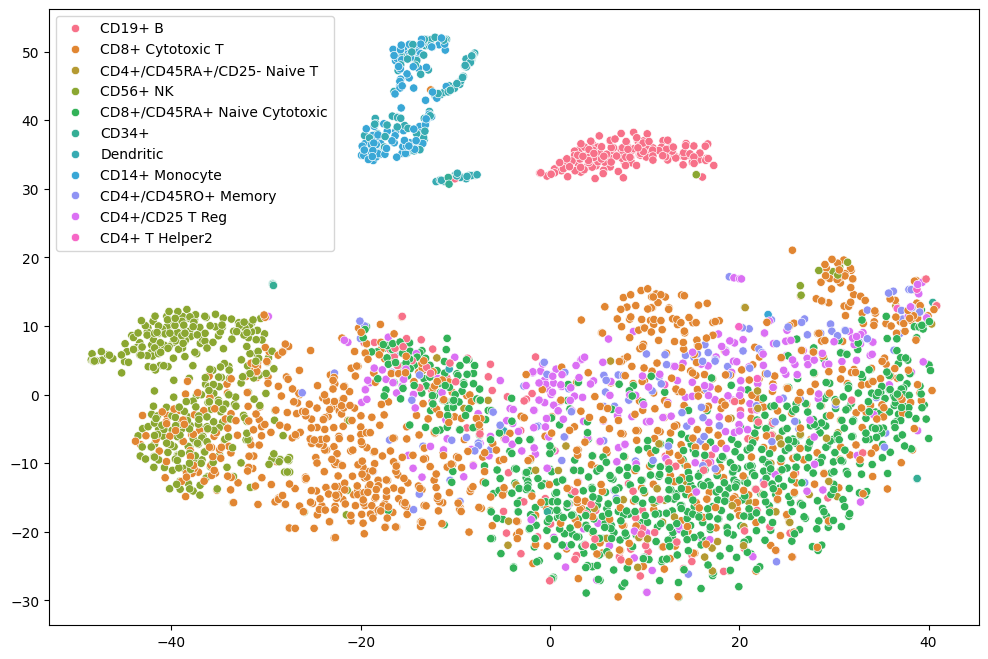

In [15]:
fig,ax = plt.subplots(figsize=(12,8))
sns.scatterplot( x = tsne.embedding_[:,0],
               y = tsne.embedding_[:,1],
               hue = cell_type_valid,ax=ax)

## build the data loaders

**exercise:** build the dataLoaders, with a batch size of 256

In [18]:
# %load solutions/AE_dataload.py

# simple autoencoder

## model building

Here we the original paper which uses only 2 layers for the encoder and decoder so we'll follow this design.

Architecture:
 - encoder: 
        - layer input size > hidden size
        - layer hidden size > latent space size
 - decoder:
        - layer latent space size > hidden size
        - layer hidden size > layer input size
    

layer structure : Dropout > linear > ReLU
     


**exercise:** implement the simple auto-encoder with the following specifications:

In [19]:
input_dim = 949  
hidden_dim=[500] 
latent_dim = 100 
[input_dim] + hidden_dim + [latent_dim] + hidden_dim + [input_dim]

[949, 500, 100, 500, 949]

In [23]:
### test your model with this line:
print(pms.summary(model, torch.zeros(1,949).to(device), show_input=True))

-----------------------------------------------------------------------
      Layer (type)         Input Shape         Param #     Tr. Param #
         Dropout-1            [1, 949]               0               0
          Linear-2            [1, 949]         475,000         475,000
            ReLU-3            [1, 500]               0               0
         Dropout-4            [1, 500]               0               0
          Linear-5            [1, 500]          50,100          50,100
            ReLU-6            [1, 100]               0               0
         Dropout-7            [1, 100]               0               0
          Linear-8            [1, 100]          50,500          50,500
            ReLU-9            [1, 500]               0               0
        Dropout-10            [1, 500]               0               0
         Linear-11            [1, 500]         475,449         475,449
           ReLU-12            [1, 949]               0               0
Total

---

In [24]:
# %load solutions/AE_model.py

In [25]:
### test your model with this line:
print(pms.summary(model, torch.zeros(1,949).to(device), show_input=True))

-----------------------------------------------------------------------
      Layer (type)         Input Shape         Param #     Tr. Param #
         Dropout-1            [1, 949]               0               0
          Linear-2            [1, 949]         475,000         475,000
            ReLU-3            [1, 500]               0               0
         Dropout-4            [1, 500]               0               0
          Linear-5            [1, 500]          50,100          50,100
            ReLU-6            [1, 100]               0               0
         Dropout-7            [1, 100]               0               0
          Linear-8            [1, 100]          50,500          50,500
            ReLU-9            [1, 500]               0               0
        Dropout-10            [1, 500]               0               0
         Linear-11            [1, 500]         475,449         475,449
           ReLU-12            [1, 949]               0               0
Total

Our loss at this stage will be the Mean Squared Error between the input and the output:

In [26]:

model.eval()
x, = valid_dataset[:5] ## let's go with a batch of 5 samples

mseloss = nn.MSELoss()

with torch.no_grad(): ## disables tracking of gradient: prevent accidental training + speeds up computation
    x = x.to(device)
    pred = model(x)
    print( "input shape:", x.shape)
    print( "prediction shape:", pred.shape)
    print("mean squared error:", mseloss(pred,x))

input shape: torch.Size([5, 949])
prediction shape: torch.Size([5, 949])
mean squared error: tensor(0.1299, device='cuda:0')


In [27]:
## get the lower dimensional view of a data point:
model.encode(x[0])

tensor([0.0601, 0.0000, 0.0615, 0.0561, 0.1020, 0.0886, 0.0543, 0.0458, 0.0000,
        0.0058, 0.0000, 0.0413, 0.1099, 0.0000, 0.0157, 0.0390, 0.0000, 0.0000,
        0.1154, 0.0000, 0.0000, 0.0000, 0.1029, 0.0694, 0.0595, 0.0774, 0.0126,
        0.0508, 0.0000, 0.0000, 0.0883, 0.0093, 0.0476, 0.0602, 0.0304, 0.0000,
        0.0000, 0.0000, 0.0473, 0.0000, 0.0440, 0.0104, 0.0306, 0.0768, 0.0000,
        0.0516, 0.0000, 0.0212, 0.0711, 0.1085, 0.0152, 0.0000, 0.0447, 0.1192,
        0.0721, 0.0000, 0.0242, 0.0363, 0.0000, 0.0395, 0.0000, 0.0000, 0.0000,
        0.0448, 0.0000, 0.0122, 0.0019, 0.0383, 0.0000, 0.0000, 0.0000, 0.0615,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0122, 0.1452, 0.1210, 0.0000, 0.0831,
        0.0000, 0.0079, 0.0046, 0.0497, 0.0074, 0.0000, 0.0000, 0.0308, 0.0218,
        0.0375, 0.0178, 0.1241, 0.0000, 0.0482, 0.0000, 0.0000, 0.0000, 0.0142,
        0.0052], device='cuda:0')

## training the model

In [28]:
def train(dataloader, model, loss_fn, optimizer , patience = 10 ,  echo = True , echo_batch = False):
    
    size = len(dataloader.dataset) # how many batches do we have
    model.train() #     Sets the module in training mode.
    
    for batch, (X,) in enumerate(dataloader): # for each batch
        X = X.to(device) # send the data to the GPU or whatever device you use for training

        # Compute prediction error
        pred = model(X)              # prediction for the model -> forward pass
        loss = loss_fn(pred, X)      # loss function from these prediction        
        
        # Backpropagation
        loss.backward()              # backward propagation 
        #                            https://ml-cheatsheet.readthedocs.io/en/latest/backpropagation.html
        #                            https://pytorch.org/tutorials/beginner/basics/autogradqs_tutorial.html
        
        optimizer.step()             
        optimizer.zero_grad()        # reset the gradients
                                     # https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch

        if echo_batch:
            current =  (batch) * dataloader.batch_size +  len(X)
            print(f"Train loss: {loss.item():>7f}  [{current:>5d}/{size:>5d}]")
    
    if echo:
        print(f"Train loss: {loss.item():>7f}")

    # return the last batch loss
    return loss.item()


In [29]:
def valid(dataloader, model, loss_fn, echo = True):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval() #     Sets the module in evaluation mode
    valid_loss = 0
    with torch.no_grad(): ## disables tracking of gradient: prevent accidental training + speeds up computation
        for (X,) in dataloader:
            X = X.to(device)
            pred = model(X)
            valid_loss += loss_fn(pred, X).item()  ## accumulating the loss function over the batches
            
    valid_loss /= num_batches

    if echo:
        print(f"Valid Error: {valid_loss:>8f}")
    ## return the average loss / batch
    return valid_loss


In [30]:
## preamble -> define the model, the loss function, and the optimizer
model = Simple_AutoEncoder(  input_dim = len(gene_ids) , 
                             hidden_dim=[500] ,
                             latent_dim = 100 , 
                             dropout_fraction = 0.05).to(device)


mseloss = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), 
                       lr = 3*10**-4) ## using the learning rate from their code


## container to keep the scores across all epochs
train_scores = []
valid_scores = []


# overfitting can be an issue here. 
# we use the early stopping implemented in https://github.com/Bjarten/early-stopping-pytorch
# initialize the early_stopping object. 
# patience: How long to wait after last time validation loss improved.
early_stopping = EarlyStopping(patience=25, verbose=False)


In [31]:
%%time
## lets do a single round, to learn how long it takes
train_scores.append( train(train_dataloader, 
                           model, 
                           mseloss, 
                           optimizer, 
                           echo = True , echo_batch = True ) )

valid_scores.append( valid(valid_dataloader, 
                           model, 
                           mseloss , 
                           echo = True) )


Train loss: 0.113029  [  256/ 7000]
Train loss: 0.110904  [  512/ 7000]
Train loss: 0.110513  [  768/ 7000]
Train loss: 0.109842  [ 1024/ 7000]
Train loss: 0.109030  [ 1280/ 7000]
Train loss: 0.100317  [ 1536/ 7000]
Train loss: 0.094274  [ 1792/ 7000]
Train loss: 0.093940  [ 2048/ 7000]
Train loss: 0.086595  [ 2304/ 7000]
Train loss: 0.082602  [ 2560/ 7000]
Train loss: 0.077882  [ 2816/ 7000]
Train loss: 0.074981  [ 3072/ 7000]
Train loss: 0.070109  [ 3328/ 7000]
Train loss: 0.067122  [ 3584/ 7000]
Train loss: 0.058761  [ 3840/ 7000]
Train loss: 0.058167  [ 4096/ 7000]
Train loss: 0.057685  [ 4352/ 7000]
Train loss: 0.052796  [ 4608/ 7000]
Train loss: 0.051227  [ 4864/ 7000]
Train loss: 0.049184  [ 5120/ 7000]
Train loss: 0.048927  [ 5376/ 7000]
Train loss: 0.048671  [ 5632/ 7000]
Train loss: 0.047690  [ 5888/ 7000]
Train loss: 0.047232  [ 6144/ 7000]
Train loss: 0.046717  [ 6400/ 7000]
Train loss: 0.046215  [ 6656/ 7000]
Train loss: 0.044559  [ 6912/ 7000]
Train loss: 0.042630  [ 7000

In [32]:
%%time

epoch = 200



for t in range(epoch):
    echo = t%10==0
    if echo:
        print('Epoch',len(train_scores)+1 )    

    train_scores.append( train(train_dataloader, 
                               model, 
                               mseloss, 
                               optimizer, 
                               echo = echo , echo_batch = False ) )

    valid_scores.append( valid(valid_dataloader, 
                               model, 
                               mseloss , 
                               echo = echo) )

    # early_stopping needs the validation loss to check if it has decresed, 
    # and if it has, it will make a checkpoint of the current model
    early_stopping(valid_scores[-1], model)

    if early_stopping.early_stop:
        print("Early stopping")
        break
        
# load the last checkpoint with the best model
model.load_state_dict(torch.load('checkpoint.pt'))


Epoch 2
Train loss: 0.038185
Valid Error: 0.038941
Epoch 12
Train loss: 0.027598
Valid Error: 0.028191
EarlyStopping counter: 1 out of 25
Epoch 22
Train loss: 0.023581
Valid Error: 0.024889
EarlyStopping counter: 2 out of 25
Epoch 32
Train loss: 0.022580
Valid Error: 0.023808
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 1 out of 25
Epoch 42
Train loss: 0.021658
Valid Error: 0.023262
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
EarlyStopping counter: 3 out of 25
EarlyStopping counter: 1 out of 25
Epoch 52
Train loss: 0.020664
Valid Error: 0.023401
EarlyStopping counter: 2 out of 25
EarlyStopping counter: 3 out of 25
EarlyStopping counter: 4 out of 25
EarlyStopping counter: 5 out of 25
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
EarlyStopping counter: 3 out of 25
EarlyStopping counter: 4 out of 25
EarlyStopping counter: 5 out of 25
Epoch 62
Train loss: 0.0

<timed exec>:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


<All keys matched successfully>

Text(0, 0.5, 'MSE loss')

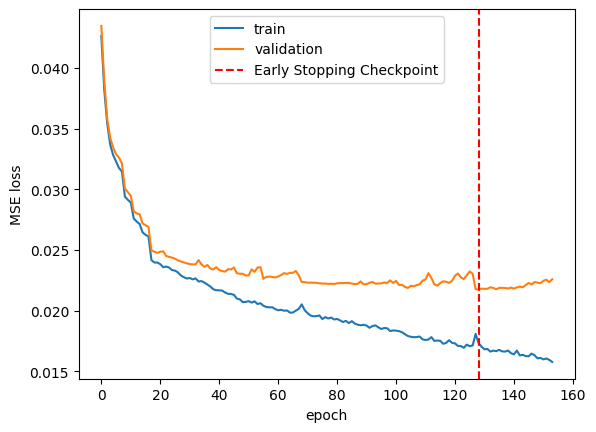

In [33]:
plt.plot(train_scores , label = 'train')
plt.plot(valid_scores, label = 'validation')
plt.axvline(np.argmin(valid_scores), linestyle='--', color='r',label='Early Stopping Checkpoint')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('MSE loss')

In [35]:
x, = valid_dataset[:]
valid_encoded = model.encode( x.to(device) )

CPU times: user 11min 16s, sys: 547 ms, total: 11min 16s
Wall time: 22.4 s


<Axes: >

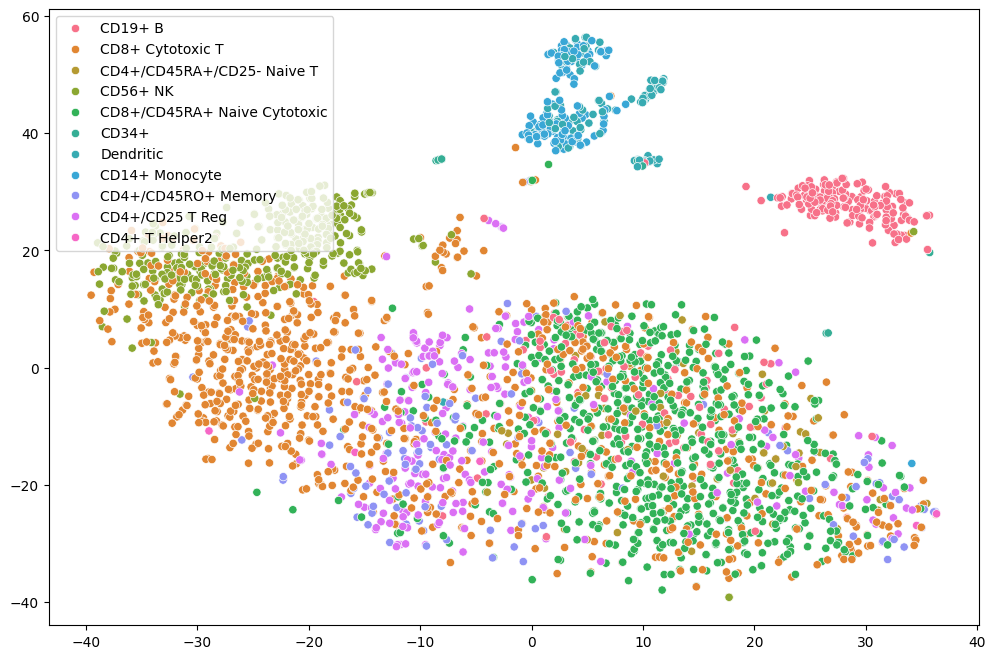

In [36]:
%%time

tsne = TSNE(n_components=2)
tsne.fit( valid_encoded.cpu().numpy() )

fig,ax = plt.subplots(figsize=(12,8))
sns.scatterplot( x = tsne.embedding_[:,0],
               y = tsne.embedding_[:,1],
               hue = cell_type_valid,ax=ax)

# from autoencoder to imputer

To go from an autoencoder to a imputer, we will switch the loss function to make it focus on the points where we have some data and disregards points were the input data is null.

In [37]:
a = torch.Tensor([[0,1,0,2,0,3],
                  [1,1,0,0,0,3]]) # X
b = torch.Tensor([[1,2,1,1,1,2],
                  [0,2,1,2,1,2]]) # prediction

In [38]:
## basic Squared Error:
(a-b)**2

tensor([[1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 4., 1., 1.]])

In [40]:
a!=0

tensor([[False,  True, False,  True, False,  True],
        [ True,  True, False, False, False,  True]])

In [41]:
## Squared Error where 0s in the original data are masked:
non_zero_mask = (a!=0)
(a-b)**2 * non_zero_mask

tensor([[0., 1., 0., 1., 0., 1.],
        [1., 1., 0., 0., 0., 1.]])

In [42]:
## and to compute a mean, we sum and divide by the number of non-zeros
SE = torch.sum((a-b)**2 * non_zero_mask)
N0 = torch.sum( non_zero_mask )
SE/N0

tensor(1.)

In [43]:
def maskedMeanSquareError(output, target):
    non_zero_mask = (target!=0)
    SE = torch.sum((output - target)**2 * non_zero_mask)
    N0 = torch.sum(non_zero_mask)
    return SE/N0
maskedMeanSquareError(b, a)

tensor(1.)

In [47]:
x, = valid_dataset[:5]
x = x.to(device)
pred = model(x)

mseloss( pred,x )

tensor(0.0234, device='cuda:0', grad_fn=<MseLossBackward0>)

In [48]:
maskedMeanSquareError(pred, x)

tensor(0.0476, device='cuda:0', grad_fn=<DivBackward0>)

### synthetic dataset for testing

In [49]:
## same as the original dataset, but with 90% of 0s
fname_input = "data/single_cell/example.msk90.hd5"
orientation = 'cell_row'  # cell_row/gene_row

In [50]:
df_tmp = pd.read_hdf(fname_input)

number_0 = (df_tmp != 0).sum().sum()

print("shape is {}".format(df_tmp.shape))
print('non-zero count is {}'.format( number_0 ))
print('non-zero rate  is {:.3f}'.format(number_0 / df_tmp.size ))

shape is (10000, 949)
non-zero count is 949319
non-zero rate  is 0.100


In [51]:
## log10 transformation 
pseudocount = 1

input_sparse_df = np.log10( df_tmp.transpose() + pseudocount ).transpose()

Let's separate training and validation set

In [52]:
valid_fraction = 0.3
valid_size = int( m * valid_fraction )
train_size = m - valid_size


np.random.seed(1884)
arr = np.arange(m)
np.random.shuffle(arr)

X_train = input_sparse_df.iloc[ arr[:train_size] , : ].to_numpy()
X_valid = input_sparse_df.iloc[ arr[train_size:] , : ].to_numpy()

print('train: {}'.format(train_size))
print('valid: {}'.format(valid_size))

train: 7000
valid: 3000


In [53]:
cell_type_train = list( cell_types.loc[ input_sparse_df.index[ arr[:train_size] ] , 'celltype' ] )
cell_type_valid = list( cell_types.loc[ input_sparse_df.index[ arr[train_size:] ] , 'celltype' ] )

In [54]:
gene_ids = input_df.columns

train_cell_ids = input_df.index[ arr[:train_size] ]
valid_cell_ids = input_df.index[ arr[train_size:] ]

In [55]:
gc.collect()
print("memory usage: {}Mb".format(usage()))

memory usage: 1569.6Mb


In [56]:
%%time
pca_valid = PCA().fit( X_valid )
x_pca = pca_valid.transform( X_valid )
pca_valid.explained_variance_ratio_[:10]

CPU times: user 15min 57s, sys: 76.5 ms, total: 15min 58s
Wall time: 31.9 s


array([0.02021433, 0.01943803, 0.01604629, 0.01513427, 0.01421431,
       0.01378829, 0.01338011, 0.01263749, 0.01192714, 0.01152175])

CPU times: user 19min 58s, sys: 703 ms, total: 19min 58s
Wall time: 39.6 s


<Axes: >

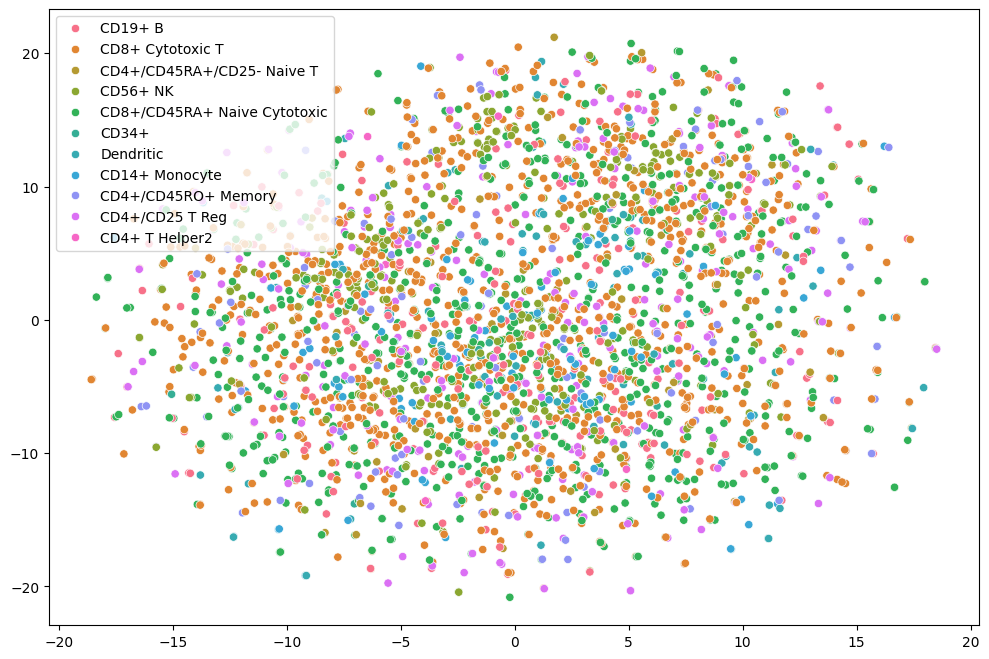

In [57]:
%%time
tsne = TSNE(n_components=2)
tsne.fit( x_pca[:,:100] )
fig,ax = plt.subplots(figsize=(12,8))
sns.scatterplot( x = tsne.embedding_[:,0],
               y = tsne.embedding_[:,1],
               hue = cell_type_valid,ax=ax)

## build the data loaders

In [58]:
batch_size = 256

In [59]:
# create your dataset
train_dataset = TensorDataset( torch.Tensor(X_train) ) 

## creating a dataloader
train_dataloader = DataLoader( train_dataset , batch_size = batch_size ) 

In [60]:
# create your dataset
valid_dataset = TensorDataset( torch.Tensor(X_valid) ) 

## creating a dataloader
valid_dataloader = DataLoader(valid_dataset , batch_size = batch_size )

In [61]:
x, = train_dataset[:]
torch.sum( x == 0 ) / torch.numel( x )

tensor(0.8999)

In [62]:
x, = valid_dataset[:]
torch.sum( x == 0 ) / torch.numel( x )

tensor(0.9001)

## build and train the model

In [63]:
## preamble -> define the model, the loss function, and the optimizer
model = Simple_AutoEncoder(  input_dim = len(gene_ids) , 
                             hidden_dim=[500] ,
                             latent_dim = 100 , 
                             dropout_fraction = 0.05).to(device)



#############################################
## Here we specify our custom loss function
mseloss = maskedMeanSquareError
#############################################


optimizer = torch.optim.Adam(model.parameters(), 
                       lr = 3*10**-4) ## using the learning rate from their code


## container to keep the scores across all epochs
train_scores = []
valid_scores = []


# overfitting can be an issue here. 
# we use the early stopping implemented in https://github.com/Bjarten/early-stopping-pytorch
# initialize the early_stopping object. 
# patience: How long to wait after last time validation loss improved.
early_stopping = EarlyStopping(patience=25, verbose=False)


In [64]:
%%time
## lets do a single round, to learn how long it takes
train_scores.append( train(train_dataloader, 
                           model, 
                           mseloss, 
                           optimizer, 
                           echo = True , echo_batch = True ) )

valid_scores.append( valid(valid_dataloader, 
                           model, 
                           mseloss , 
                           echo = True) )


Train loss: 0.340974  [  256/ 7000]
Train loss: 0.340514  [  512/ 7000]
Train loss: 0.335013  [  768/ 7000]
Train loss: 0.332650  [ 1024/ 7000]
Train loss: 0.333647  [ 1280/ 7000]
Train loss: 0.318880  [ 1536/ 7000]
Train loss: 0.305779  [ 1792/ 7000]
Train loss: 0.313485  [ 2048/ 7000]
Train loss: 0.297378  [ 2304/ 7000]
Train loss: 0.292043  [ 2560/ 7000]
Train loss: 0.274618  [ 2816/ 7000]
Train loss: 0.263032  [ 3072/ 7000]
Train loss: 0.237874  [ 3328/ 7000]
Train loss: 0.222149  [ 3584/ 7000]
Train loss: 0.201456  [ 3840/ 7000]
Train loss: 0.187316  [ 4096/ 7000]
Train loss: 0.173815  [ 4352/ 7000]
Train loss: 0.162909  [ 4608/ 7000]
Train loss: 0.163484  [ 4864/ 7000]
Train loss: 0.154848  [ 5120/ 7000]
Train loss: 0.156356  [ 5376/ 7000]
Train loss: 0.152416  [ 5632/ 7000]
Train loss: 0.143165  [ 5888/ 7000]
Train loss: 0.127607  [ 6144/ 7000]
Train loss: 0.119735  [ 6400/ 7000]
Train loss: 0.110524  [ 6656/ 7000]
Train loss: 0.105887  [ 6912/ 7000]
Train loss: 0.105203  [ 7000

In [65]:
%%time

epoch = 200



for t in range(epoch):
    echo = t%10==0
    if echo:
        print('Epoch',len(train_scores)+1 )    

    train_scores.append( train(train_dataloader, 
                               model, 
                               mseloss, 
                               optimizer, 
                               echo = echo , echo_batch = False ) )

    valid_scores.append( valid(valid_dataloader, 
                               model, 
                               mseloss , 
                               echo = echo) )

    # early_stopping needs the validation loss to check if it has decresed, 
    # and if it has, it will make a checkpoint of the current model
    early_stopping(valid_scores[-1], model)

    if early_stopping.early_stop:
        print("Early stopping")
        break
        
# load the last checkpoint with the best model
model.load_state_dict(torch.load('checkpoint.pt'))


Epoch 2
Train loss: 0.079455
Valid Error: 0.074888
Epoch 12
Train loss: 0.049695
Valid Error: 0.048985
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
Epoch 22
Train loss: 0.044428
Valid Error: 0.044674
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
EarlyStopping counter: 1 out of 25
Epoch 32
Train loss: 0.037262
Valid Error: 0.039371
EarlyStopping counter: 1 out of 25
Epoch 42
Train loss: 0.030911
Valid Error: 0.033843
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 1 out of 25
Epoch 52
Train loss: 0.023414
Valid Error: 0.028450
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
EarlyStopping counter: 3 out of 25
EarlyStopping counter: 1 out of 25
Epoch 62
Train loss: 0.021246
Valid Error: 0.027326
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
EarlyStopping counter: 3 out of 25
EarlyStopping counter: 4 out of 25
Epoch 7

<timed exec>:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


<All keys matched successfully>

Text(0, 0.5, 'MSE loss')

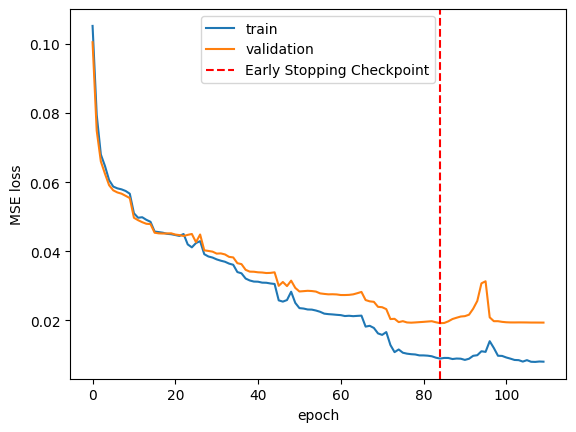

In [66]:
plt.plot(train_scores , label = 'train')
plt.plot(valid_scores, label = 'validation')
plt.axvline(np.argmin(valid_scores), linestyle='--', color='r',label='Early Stopping Checkpoint')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('MSE loss')

In [68]:
x, = valid_dataset[:]
valid_encoded = model.encode( x.to(device) )

CPU times: user 3min 4s, sys: 76.1 ms, total: 3min 4s
Wall time: 6.07 s


<Axes: >

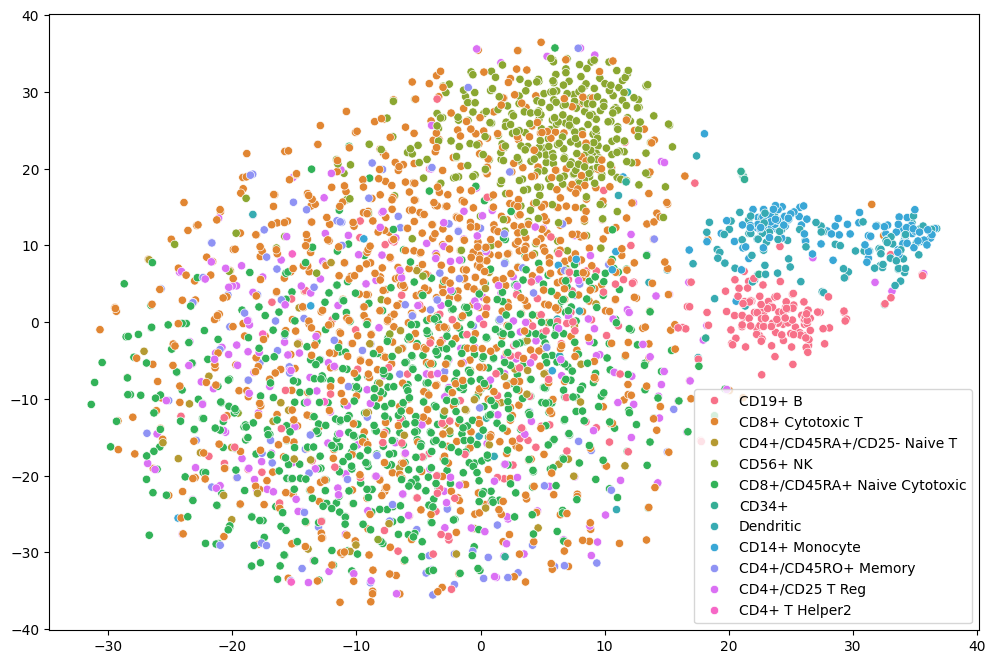

In [69]:
%%time

tsne = TSNE(n_components=2)
tsne.fit( valid_encoded.cpu().numpy() )

fig,ax = plt.subplots(figsize=(12,8))
sns.scatterplot( x = tsne.embedding_[:,0],
               y = tsne.embedding_[:,1],
               hue = cell_type_valid,ax=ax)

Looks like our masked encoder has retrieved some of the data structure despite the heavy sparsity!

In [70]:
## imputation 
with torch.no_grad():
    x, = train_dataset[:]
    train_imputed = model( x.to(device) ).cpu().numpy()
    x, = valid_dataset[:]
    valid_imputed = model( x.to(device) ).cpu().numpy()


In [71]:
## ground truth
df_truth = pd.read_hdf('data/single_cell/example.hd5')
## log10 transformation 
pseudocount = 1
df_truth = np.log10( df_truth.transpose() + pseudocount ).transpose()

In [72]:
truth_train = np.array( df_truth.loc[ train_cell_ids , : ] )
truth_valid = np.array( df_truth.loc[ valid_cell_ids , : ] )

In [73]:
## remember, the "ground truth" data already had ~67% of missing data, 
##  we do not want to focus on this for the solution assessment

train_NI_mask = ( truth_train != 0 ) & ( X_train != 0 ) # non imputed data
train_I_mask = ( truth_train != 0 ) & ( X_train == 0 ) # imputed data with a ground truth

valid_NI_mask = ( truth_valid != 0 ) & ( X_valid != 0 ) # non imputed data
valid_I_mask = ( truth_valid != 0 ) & ( X_valid == 0 ) # imputed data with a ground truth


In [74]:

# difference of non imputed in train
train_non_imputed_diff = ( train_imputed[ train_NI_mask ] - truth_train[ train_NI_mask ] )
# difference of imputed in train
train_imputed_diff = ( train_imputed[ train_I_mask ] - truth_train[ train_I_mask ] )

# difference of non imputed in valid
valid_non_imputed_diff = ( valid_imputed[ valid_NI_mask ] - truth_valid[ valid_NI_mask ] )
# difference of imputed in valid
valid_imputed_diff = ( valid_imputed[ valid_I_mask ] - truth_valid[ valid_I_mask ] )



In [ ]:
%%time

sizes = (train_non_imputed_diff.shape[0],
         train_imputed_diff.shape[0],
         valid_non_imputed_diff.shape[0],
         valid_imputed_diff.shape[0])

sns.violinplot(x = np.concatenate( [train_non_imputed_diff ,
                                    train_imputed_diff , 
                                    valid_non_imputed_diff, 
                                    valid_imputed_diff]),
            y = ['train']*(sizes[0]+sizes[1]) + ['valid']*(sizes[2]+sizes[3]),
            hue = ['non-imputed']*sizes[0] + ['imputed']*sizes[1] + ['non-imputed']*sizes[2] + ['imputed']*sizes[3] )

In [ ]:

print('train, non-imputed - absolute error:')
V = np.abs(train_non_imputed_diff)
print('\tq0.05: {:.4f} , q0.5: {:.4f} , q0.95: {:.4f}'.format( *(np.quantile(V , [0.05,0.5,0.95])) ))
print('train, imputed - absolute error:')
V = np.abs(train_imputed_diff)
print('\tq0.05: {:.4f} , q0.5: {:.4f} , q0.95: {:.4f}'.format( *(np.quantile(V , [0.05,0.5,0.95])) ))
print('valid, non-imputed - absolute error:')
V = np.abs(valid_non_imputed_diff)
print('\tq0.05: {:.4f} , q0.5: {:.4f} , q0.95: {:.4f}'.format( *(np.quantile(V , [0.05,0.5,0.95])) ))
print('valid, imputed - absolute error:')
V = np.abs(valid_imputed_diff)
print('\tq0.05: {:.4f} , q0.5: {:.4f} , q0.95: {:.4f}'.format( *(np.quantile(V , [0.05,0.5,0.95])) ))